# The Social Web Research Project

In this project, Experts of Stackoverflow Question-Answering community are found.
First installing the libraries.

In [1]:
!pip install networkx
!pip install matplotlib
!pip install scipy
!pip install pandas

You should consider upgrading via the 'U:\Courses\Social Web\sw_virtual_environment\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'U:\Courses\Social Web\sw_virtual_environment\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'U:\Courses\Social Web\sw_virtual_environment\Scripts\python.exe -m pip install --upgrade pip' command.


You should consider upgrading via the 'U:\Courses\Social Web\sw_virtual_environment\Scripts\python.exe -m pip install --upgrade pip' command.


## importing necessary libraries

In [2]:
import networkx as nx
from matplotlib import pyplot as plt
import csv
from datetime import datetime
from prettytable import PrettyTable
import pandas as pd
import numpy as np



Generating empty graph
G_with_scores = graph with edges that are aggregated sum of scores of answers a destination node(user) gave to source node(user)
G_without_scores = graph with edges that are aggregated count of answers a destination node(user) gave to source node(user)

In [3]:
G_with_scores = nx.DiGraph()
G_without_scores = nx.DiGraph()

Reading the edges from CSV file and generating raw edges and appending them as tuples inside a list

In [4]:
edges = []

def read_csv(path):
    with open(path, "r") as csvfile:
        graph_reader = csv.reader(csvfile, delimiter=',', quotechar='"')
        data_row_count = 0
        list = []
        header = next(graph_reader)
        print(f'Column names are {", ".join(header)}')
        number_of_columns = len(header)
        for row in graph_reader:
            temp_list = []
            for index in range(number_of_columns):
                temp_list.append(row[index])
            list.append(tuple(temp_list))
            data_row_count += 1
        now = datetime.now()
        current_time = now.strftime("%H:%M:%S")
        print(f'Processed {data_row_count} lines = ', current_time)
        return list

edges = read_csv('files/python-tag-data_2021-01-01_to_2021-12-03.csv')

Column names are OwnerUserId, OwnerUserId, score
Processed 109585 lines =  16:32:38


## Aggregate data
We considered 2 approaches to aggregate the edges of graph:

1- function <code>aggregate</code> aggregates edges on number of specific user answers to someone's multiple questions. for example if there be 4 record of <code>"1223", "5233"</code> in csv file, this functions considers 4 as weight of the corresponding edge from node(user) "1223" to user "5233".

2- function <code>aggregate_with_scores</code> aggregates score of each answer given by user and sum them as aggregate function. for example if there be 4 record of <code>"1223", "5233"</code> in csv file with score of respectively 5, 6, 10 and 2, this functions considers 23 as weight of the corresponding edge from node(user) "1223" to user "5233".

we will use them for different algorithms and will show how considering the score of answers affects the evaluation of our work.

In [5]:
def aggregate(G, edges):
    for edge in edges:
            from_node, to_node = edge[0], edge[1]
            if G.has_edge(from_node, to_node):
                # we added this one before, just increase the weight by one
                G[from_node][to_node]['weight'] += 1
            else:
                # new edge. add with weight=1
                G.add_edge(from_node, to_node, weight=1)

def aggregate_with_scores(G, edges):
    for edge in edges:
            from_node, to_node, score = edge[0], edge[1], float(edge[2])
            if G.has_edge(from_node, to_node):
                # we added this one before, just increase the weight by one
                G[from_node][to_node]['weight'] += score
            else:
                # new edge. add with weight=1
                G.add_edge(from_node, to_node, weight=score)

aggregate(G_without_scores, edges)
aggregate_with_scores(G_with_scores, edges)

## def remove_negative_edges():
    ## todo

## Social Network Analysis Algorithms

Based on our literature work, Most researches that used social network analysis aproaches to find experts tried to use PageRank and applied some feature of their dataset to the algorithm. We shall do the same and we considered score of answers as feature of our dataset to indicate experties of each user.

So the <code>aggregate</code> function counts the number of times a user answered another user as feature. and the <code>aggregate_with_scores</code> considers scores of answeres each user got to another user's questions in specific tag.

There is a parameter called damping factor which indicates the probability of jumping to another node when algorithm stuck in the loop. In practice 0.85 is the best number for real data use. damping factor in the networkx is known as <code>alpha</code> which is an argument but since the default value that networkx also chose is 0.85, we did not pass it throught the pagerank method. pagerank algorthm is recersive algorithm which we must state how many times it should be run. As much more as it runs, the scores of each nodes starts to tend to reach a number and after some iteration, they will not change which is the point that score of pagerank is final. networkx has argument of <code>max_iter</code> that is the number of iteration that algorithm runs which by default is 100.

After calculating the pagerank of each node, we need to sort the score to see which node has highest score (importance) in the graph. Based on scenario of our graph which is a directed graph, that means that user has the highest experties.

In [13]:
gws_pagerank = nx.pagerank(G_with_scores)
gws_hits = nx.hits(G_with_scores)
gws_in_degree = G_with_scores.in_degree(weight='weight')

gws_sen_rank = sorted(gws_pagerank.items(), key=lambda x: x[1], reverse=True)
gws_Hits_Rank = sorted(gws_hits[1].items(), key=lambda x: x[1], reverse=True)
gws_in_Degree_Centrality_Rank = sorted(gws_in_degree, key=lambda x: x[1], reverse=True)


Sorted_PageRank_UserId = [x[0] for x in gws_sen_rank]
PageRank_Score = [x[1] for x in gws_sen_rank]

Sorted_Hits_Rank_UserId = [x[0] for x in gws_Hits_Rank]
Hits_Rank_Score = [x[1] for x in gws_Hits_Rank]

Sorted_Degree_Centrality_UserId = [x[0] for x in gws_in_Degree_Centrality_Rank]
Degree_Centrality_Rank_Score = [x[1] for x in gws_in_Degree_Centrality_Rank]




data = {'Sorted_PageRank_UserId': Sorted_PageRank_UserId,'PageRank_Score': PageRank_Score, 'Sorted_Hits_Rank_UserId': Sorted_Hits_Rank_UserId , 'Hits_Rank_Score' : Hits_Rank_Score, 'Sorted_Degree_Centrality_UserId' : Sorted_Degree_Centrality_UserId, 'Degree_Centrality_Rank_Score' : Degree_Centrality_Rank_Score}
df = pd.DataFrame(data)
print(df)


###########################################

gwos_pagerank = nx.pagerank(G_without_scores)
gwos_hits = nx.hits(G_without_scores)
gwos_in_degree = nx.in_degree_centrality(G_without_scores)

gwos_sen_rank = sorted(gwos_pagerank.items(), key=lambda x: x[1], reverse=True)
gwos_Hits_Rank = sorted(gwos_hits[1].items(), key=lambda x: x[1], reverse=True)
gwos_in_Degree_Centrality_Rank = sorted(gwos_in_degree.items(), key=lambda x: x[1], reverse=True)


Sorted_PageRank_UserId = [x[0] for x in gwos_sen_rank]
PageRank_Score = [x[1] for x in gwos_sen_rank]

Sorted_Hits_Rank_UserId = [x[0] for x in gwos_Hits_Rank]
Hits_Rank_Score = [x[1] for x in gwos_Hits_Rank]

Sorted_Degree_Centrality_UserId = [x[0] for x in gwos_in_Degree_Centrality_Rank]
Degree_Centrality_Rank_Score = [x[1] for x in gwos_in_Degree_Centrality_Rank]



      Sorted_PageRank_UserId  PageRank_Score Sorted_Hits_Rank_UserId  \
0                   16343464        0.009493                 2288659   
1                   15497888        0.006368                12299000   
2                    2901002        0.006077                  565635   
3                   10035985        0.003752                 5168011   
4                    6361531        0.003203                 2705542   
...                      ...             ...                     ...   
78299               13789135       -0.000003                 4885131   
78300                1271826       -0.000005                16238491   
78301               16911595       -0.000009                10682289   
78302                2142228       -0.000009                11631308   
78303               16540897       -0.000017                14516752   

       Hits_Rank_Score Sorted_Degree_Centrality_UserId  \
0         6.738083e-01                         2901002   
1         4.178065e

## Evaluation
Before we introduce our evaluation methods, we must introduce which data we are comparing our data to.
For our research we found this link on <a href="https://stackoverflow.com/tags/python/topusers">stackoverflow website</a>. In this website we see the top users in python tag. But we need this data for the date range that we used for our research. So we need to extract our own data from stackoverflow to get this top users in tags. And not to mention that this link shows top user for specific tag. But we aimed to find all tags related to python. for example that link only shows top users in tag "python" but this is not only tag related to python. There are tags like "python-2.7", "python-idle" and etc that must be considered because they are also related to subject "python".
For this purpose we proposed our own query to extract the top users from stackoverflow. Based on the mentioned link above, top users that stackoverflow release (data on this link is updated weekly) are based on scores of answer they give in specific tag. So we conducted our own query to extract this data. The query is as follows:

``` mysql
select a.OwnerUserId as Answerer_ID, sum(a.score) as Sum_Answerer_Score
from posts as q join posts as a on  q.Id = a.ParentId join users as u on a.OwnerUserId = u.Id
where q.CreationDate < GETDATE()
and   q.CreationDate >= '2021-01-01 00:00:00'
and   q.PostTypeId = 1
and   a.PostTypeId = 2
and   a.OwnerUserId IS NOT NULL
and   q.Tags LIKE '%python%'
group by a.OwnerUserId
order by Sum_Answerer_Score desc
```
This query aims to get data from start of 2021 until the day that the day query is running. So be aware that the csv files that you see in the project files are for queries that was run on 12/4/2021

to test our query you can remove the CreationDate conditions and see which users are top users of tags in python and compare it with data in the <a href="https://stackoverflow.com/tags/python/topusers">stackoverflow website</a>. Be aware that you must see abit of difference in number for 2 reasons:
1- the data on that link is not updated frequently (only weekly)
2- we consider multiple tags that are related to "python" but the link only considers tag "python". So defenetly numbers of scores that you see in the result of our query must be a bit higher.

In this section we are going to do 2 evaluation on our work:
1- TOPK: In this evaluation we aim to see how many of our top k users appeared in top k users that considered top users in stackoverflow.
2- Spearman Correlation: The TOPK evaluation helps us know how good was our expert detection process. But it does not give us good information how was precision of our ranking process. That is why we considered spearman correlation to determine the correlation between ranking that stackoverflow gives and ranking that we found after process of expert finding

In [16]:
import scipy.stats as ss

top_user_count = 100
def topk_evaluation(user_ids_for_evaluation, ranked_user_ids, user_count):
    # user_ids_for_evaluation_sorted = sorted(user_ids_for_evaluation, key=lambda x: x[1], reverse=True)
    topN = user_ids_for_evaluation[0:user_count]
    list_of_topN_user_ids = list(map(lambda x: x[0], topN))
    matched_user_id_count = 0
    for index in range(user_count):
        target = ranked_user_ids[index]
        if target in list_of_topN_user_ids:
            matched_user_id_count += 1
    match_result = matched_user_id_count/user_count
    return match_result

def spearman_evaluation(user_ids_for_evaluation, users_pagerankscore_tuple, user_count):
    list_of_topN_user_ids_by_stackoverflow = list(map(lambda x: int(x[1]), user_ids_for_evaluation))
    rank_of_topN_user_ids_by_stackoverflow  = len(list_of_topN_user_ids_by_stackoverflow) - ss.rankdata(list_of_topN_user_ids_by_stackoverflow).astype(int) + 1
    our_scores = list(map(lambda x: x[1], users_pagerankscore_tuple))
    our_rankings_by_scores  = len(our_scores) - ss.rankdata(our_scores).astype(int) + 1
    our_user_ranking_tuples = []
    for index in range(len(our_rankings_by_scores)):
        our_user_ranking_tuples.append((users_pagerankscore_tuple[index][0],our_rankings_by_scores[index]))
    stackoverflow_user_ranking_tuples = []
    for index in range(len(rank_of_topN_user_ids_by_stackoverflow)):
        stackoverflow_user_ranking_tuples.append((user_ids_for_evaluation[index][0],rank_of_topN_user_ids_by_stackoverflow[index]))

    our_ranking_for_evaluation = list(map(lambda x: int(x[1]), our_user_ranking_tuples))
    temp_stackoverflow_userids = list(map(lambda x: x[0], stackoverflow_user_ranking_tuples))
    stackoverflow_ranking_for_evaluation = []
    for index in range(user_count):
        try:
            target_to_find = our_user_ranking_tuples[index][0]
            found_index = temp_stackoverflow_userids.index(target_to_find)
            stackoverflow_ranking_for_evaluation.append(stackoverflow_user_ranking_tuples[found_index][1])
        except:
            continue

    return ss.spearmanr(our_ranking_for_evaluation[0:user_count], stackoverflow_ranking_for_evaluation[0:user_count])[0]

evaluation_data = read_csv('files/2021-01-01_to_2021-12-03_stackoverflow_top_users.csv')

#### for with_scored_graph

sen_rank_evalauation_result = topk_evaluation(evaluation_data, list(map(lambda x: x[0], gws_sen_rank)), top_user_count)
spearman_evaluation_sen = spearman_evaluation(evaluation_data, gws_sen_rank, top_user_count)

#Hits_Rank

Hits_Rank_evalauation_result = topk_evaluation(evaluation_data, list(map(lambda x: x[0], gws_Hits_Rank)), top_user_count)
spearman_evaluation_Hits = spearman_evaluation(evaluation_data, gws_Hits_Rank, top_user_count)


#Degree_Centrality_Rank

Degree_Centrality_Rank_evalauation_result = topk_evaluation(evaluation_data, list(map(lambda x: x[0], gws_in_Degree_Centrality_Rank)), top_user_count)
spearman_evaluation_Degree_Centrality = spearman_evaluation(evaluation_data, gws_in_Degree_Centrality_Rank, top_user_count)

#### for without_scored_graph

gwos_sen_rank_evalauation_result = topk_evaluation(evaluation_data, list(map(lambda x: x[0], gwos_sen_rank)), top_user_count)
gwos_spearman_evaluation_sen = spearman_evaluation(evaluation_data, gwos_sen_rank, top_user_count)

#Hits_Rank

gwos_Hits_Rank_evalauation_result = topk_evaluation(evaluation_data, list(map(lambda x: x[0], gwos_Hits_Rank)), top_user_count)
gwos_spearman_evaluation_Hits = spearman_evaluation(evaluation_data, gwos_Hits_Rank, top_user_count)


#Degree_Centrality_Rank

gwos_Degree_Centrality_Rank_evalauation_result = topk_evaluation(evaluation_data, list(map(lambda x: x[0], gwos_in_Degree_Centrality_Rank)), top_user_count)
gwos_spearman_evaluation_Degree_Centrality = spearman_evaluation(evaluation_data, gwos_in_Degree_Centrality_Rank, top_user_count)

Column names are Answerer_ID, Sum_Answerer_Score
Processed 50000 lines =  16:50:18


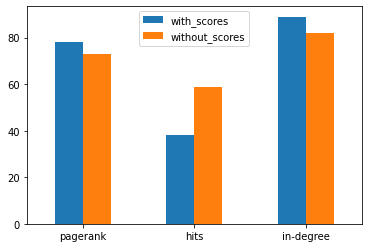

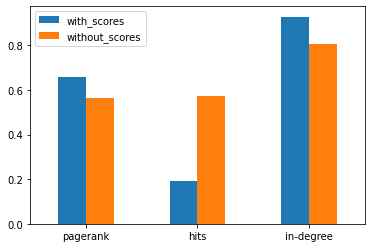

In [17]:
# data to plot

n_groups = 2
gws_pagerank = sen_rank_evalauation_result*100
gws_Hits = Hits_Rank_evalauation_result*100
gws_Degree_Centrality = Degree_Centrality_Rank_evalauation_result*100

gwos_pagerank = gwos_sen_rank_evalauation_result*100
gwos_Hits = gwos_Hits_Rank_evalauation_result*100
gwos_Degree_Centrality = gwos_Degree_Centrality_Rank_evalauation_result*100

# create plot
speed = [gws_pagerank, gws_Hits, gws_Degree_Centrality]
lifespan = [gwos_pagerank, gwos_Hits, gwos_Degree_Centrality]
index = ['pagerank', 'hits', 'in-degree']
df = pd.DataFrame({'with_scores': speed,
                   'without_scores': lifespan}, index=index)
ax = df.plot.bar(rot=0)


n_groups = 2
gws_pagerank = spearman_evaluation_sen
gws_Hits = spearman_evaluation_Hits
gws_Degree_Centrality = spearman_evaluation_Degree_Centrality

gwos_pagerank = gwos_spearman_evaluation_sen
gwos_Hits = gwos_spearman_evaluation_Hits
gwos_Degree_Centrality = gwos_spearman_evaluation_Degree_Centrality

speed = [gws_pagerank, gws_Hits, gws_Degree_Centrality]
lifespan = [gwos_pagerank, gwos_Hits, gwos_Degree_Centrality]
index = ['pagerank', 'hits', 'in-degree']
df = pd.DataFrame({'with_scores': speed,
                   'without_scores': lifespan}, index=index)
ax = df.plot.bar(rot=0)
# create plot




## Visualization

<span style="color: red">BEWARE</span>: The number of nodes are edges are large in this project. I do not recommend running this part because it might take hours to render the results.

In [9]:
#labels = nx.get_edge_attributes(G,'weight')
#pos = nx.spring_layout(G)
#nx.draw(G, pos, with_labels = True, node_color="#f86e00", connectionstyle='arc3, rad = 0.3')
#nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)


# plt.show()